In [1]:
import os #for directory manipulation
import re # for text manipulation
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import random as rand
from string import punctuation 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk import ngrams
import itertools

nlp = spacy.load('en_core_web_lg')



In [2]:
#loading case ids and decision for problem 5
case_reversed = pd.read_csv(os.path.join(os.getcwd(),"case_reversed.csv"))

#getting the directory of cases and loading them into a list
path_cases = os.path.join(os.getcwd(), "cases")
filenames = os.listdir(path_cases)

#sampling from all the docs, I sample 200 files mostly because the arrays become too large in problem 8 & 9.
filenames = rand.sample(filenames, 200)
filenames.sort()

#preassigning some lists for the eponymous variables
docs = []
years = []
reversals = []
ids = []   
 
#NOTE: occasionally this is unable to load a file, unknown why. Rerunning solves the problem
for filename in filenames:
    doc = open(os.path.join(path_cases, filename), 'r')
    docs.append(doc.read())
    years.append(filename[0:4])
    ids.append(filename[5:11])


doc_year = pd.DataFrame({"year": years, "id": ids,  "text": docs})
doc_year = pd.merge(doc_year, case_reversed,
                    left_on = "id",
                    right_on = "caseid",
                    how = "left"
                   )

#filter out those with no match in the case decisions, as we have no clue what missingness means here
doc_year = doc_year.loc[doc_year["case_reversed"].notna()]

doc_year.head(5)

year      id                                               text  caseid  \
0  1924  X3OH3J   JOHNSON , Circuit Judge.\nThis is a patent in...  X3OH3J   
1  1925  X9VBMG   BINGHAM , Circuit Judge.\nThis was an action ...  X9VBMG   
2  1926  X3BCJB   BRYAN , Circuit Judge.\nThis is an appeal fro...  X3BCJB   
3  1926  X3BCL3   BINGHAM , Circuit Judge.\nThis is an action f...  X3BCL3   
4  1926  X3BMUH   GILBERT , Circuit Judge.\nThese two appeals p...  X3BMUH   

   case_reversed  
0            0.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0

In [3]:
##Problem 1:

#process all cases with spaCy
proc_docs = []
for doc in doc_year["text"]:
    proc_docs.append(nlp(doc))

    
#count sentences, words, and letters (I also added tokens, seemed relevant)
def sent_count(doc):
    # check the length of the list of all sentences (note that from a quick check this has a positive bias;
    # references to other cases are split into multiple sentences)
    return len(list(doc.sents))

def word_count(doc):
    # counting all tokens which contain solely alphabetic characters to proxy words
    return sum((token.is_alpha for token in doc))

def token_count(doc):
    # counts all tokens
    return len(doc)

def letter_count(doc):
    count = 0
    # finds count of letters
    # note I assume that there are no letters with accents (e.g. á é â)
    for char in doc.text:
        if re.match("[A-Za-z]", char):
            count+=1
    return count

#creating dataframe for storing the relevant features. 
doc_features = pd.DataFrame()
doc_features["year"] = doc_year["year"]

doc_features["n_sents"] = list(map(sent_count, proc_docs))
doc_features["n_words"] = list(map(word_count, proc_docs))
doc_features["n_letters"] = list(map(letter_count, proc_docs))
doc_features["n_tokens"] = list(map(token_count, proc_docs))


#showing some exemplary counts
doc_features.head(5)

year  n_sents  n_words  n_letters  n_tokens
0  1924       77     2848      13313      3355
1  1925       69     3900      18300      4512
2  1926       44     1323       5956      1523
3  1926       25     1556       7414      1919
4  1926       34      886       4169      1127

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027D0F2F6D68>,
      dtype=object)

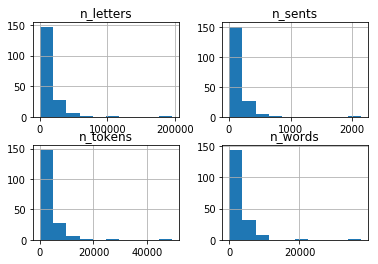

In [4]:
#showing the histogram of the counts
doc_features.hist()

In [5]:
#Problem 2: Use the spaCy parts of speech (POS) tags to count number of nouns, verbs, and adjectives in each document. Visualize POS frequency by year.
doc_features["spacy_doc"] = proc_docs

#defining functions to count
def count_verbs(doc):
    verb = 0
    for token in doc:
        if token.pos_ == "VERB":
            verb += 1
    return verb

def count_nouns(doc):
    noun = 0
    for token in doc:
        if token.pos_ == "NOUN":
             noun += 1 
    return noun

def count_adjs(doc):
    adj = 0
    for token in doc:
        if token.pos_ == "ADJ":
             adj += 1
    return adj

#creating lists of the counts for each document in the data
verbs = []
nouns = []
adjs = []
for doc in doc_features["spacy_doc"]:
    verbs.append(count_verbs(doc))
    nouns.append(count_nouns(doc))
    adjs.append(count_adjs(doc))
    
doc_features["verbs"] = verbs
doc_features["nouns"] = nouns
doc_features["adjs"] = adjs

print("Below I plot the counts of word types by year. All types of word go up over time, probably just indicating that speeches got longer. \n Note that I have normalized by year because the random sample may oversample some years")

Below I plot the counts of word types by year. All types of word go up over time, probably just indicating that speeches got longer. 
 Note that I have normalized by year because the random sample may oversample some years


Mean freq of verbs by year


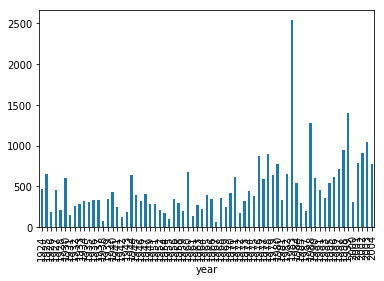

In [6]:
print("Mean freq of verbs by year")
norm_verbs = doc_features.groupby(["year"])['verbs'].mean()
norm_verbs.plot.bar(x = "year", y = "verbs")

In [7]:
print("Mean freq of nouns by year")
norm_nouns = doc_features.groupby(["year"])['nouns'].mean()
norm_nouns.plot.bar(x = "year", y = "nouns")

Mean freq of nouns by year


Mean freq of adjectives by year


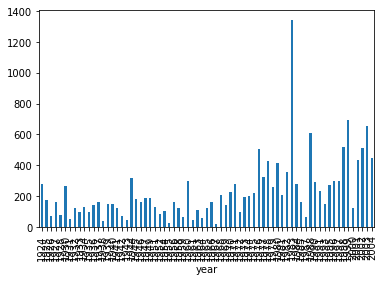

In [8]:
print("Mean freq of adjectives by year")
norm_adjs = doc_features.groupby(["year"])['adjs'].mean()
norm_adjs.plot.bar(x = "year", y = "adjs")

In [9]:
#Problem 3: Follow the steps in lecture to normalize your corpus (e.g., removing punctuation) 
# and discuss your choices about what information to exclude. Using the normalized tokens, make a 
# feature set of all trigrams that end in a noun. 

# Normalization that I have done:
# Remove punctuation: makes data much easier to work with - punctuation would add an almost entirely noise vector
# Remove numbers: numbers are unlikely to be repeated in other texts (though it may be that certain case numbers are useful 
# in a legal context), so they will usually add an unnecessary/nonpredictive feature - I retain a hash symbol just in case
# since court documents may refer to specific laws etc
# Retain stopwords: They may be part of multi-word expressions, as discussed in lecture
# Capitalization: Removed (by taking the lemma). This is important since otherwise identical may not be recognized
# as such
# Stemming: I opt to take the lemma over the stem, since there may be modified forms (past tense or similar) of the same
# trigram which will not be recognized as such otherwise 

#In the function below I remove punctuation, spaces, and symbols. I replace numbers with the hash symbol. Additionally
# I take the lemma. The returned object has the lemmas and POS tags of each token.
def normalize_text(doc):
    text_norm = []
    text_pos = []
    #TODO: remove sentences containing "v."
    for token in doc:            
        if (token.pos_ != "PUNCT") & (token.pos_ != "SPACE") & (token.pos_ != "NUM") & (token.pos_ != "SYM"):
            text_norm.append(token.lemma_)
            text_pos.append(token.pos_)
            
        elif token.pos_ == "NUM":
            text_norm.append("#")
            text_pos.append(token.pos_)
            
        #maybe add proper noun?
        #maybe remove stopwords (use nltk corpus to match against)
            
    return (pd.DataFrame({"text" : text_norm, "pos" : text_pos}))
            
        
doc_features["clean_doc"] = doc_features["spacy_doc"].apply(normalize_text)


from nltk import ngrams

#In this function I create the trigrams, and find the final POS tag of the trigram to determine if it 
# is noun-ended or not. I retain only the noun-ending ones, as per the assignment.
def end_noun_ngrams(doc):
    grams_pos = list(ngrams(doc["pos"], 3))
    grams_pos = [pos[2] for pos in grams_pos]
    
    grams = list(ngrams(doc["text"], 3))
    
    selected_grams = pd.DataFrame({"pos": grams_pos,"gram": list(map('_'.join, grams))})
    
    selected_grams = selected_grams.loc[selected_grams["pos"] == 'NOUN']
    return list(selected_grams["gram"])

#Getting the trigrams per document
doc_features["trigrams"] = [end_noun_ngrams(doc) for doc in doc_features["clean_doc"]] 

print("This contains all trigrams ending in a noun. Explicitly putting them into a dictionary is done in the course of problem 4." )
doc_features["trigrams"].head(5)

This contains all trigrams ending in a noun. Explicitly putting them into a dictionary is done in the course of problem 4.


0    [be_a_patent, a_patent_infringement, patent_in...
1    [be_an_action, action_of_tort, ryan_a_citizen,...
2    [be_an_appeal, from_a_decree, in_which_appella...
3    [be_an_action, action_for_breach, breach_of_co...
4    [these_#_appeal, present_the_question, of_the_...
Name: trigrams, dtype: object

In [10]:
#Problem 4: Make a dataframe with at least 1000 features (frequencies over trigrams ending in a noun). Standardize the 
# features to variance one while maintaining sparsity. 

#To do this, I find all unique trigrams, and compute the tf-idf scores for each one. This allows for better
# prediction since it gives a scoring of trigrams that is upweighted for being relatively rare, respectively common
# across documents, while being relatively common, respectively rare within documents. This helps choose a feature
# set, for computational efficiency

#Finding the number of valid trigrams in each doc for normalization
doc_features["n_trigrams"] = doc_features["trigrams"].apply(len)

#creating the object storing the frequencies of each trigram found across all documents
from collections import Counter
import numpy as np
docfreqs = Counter() 
termcounts = Counter()
total_length = 0
for i, row in doc_features.iterrows():
    termcounts.update(row["trigrams"]) # how many times each trigram appears across all documents
    total_length += row['n_trigrams'] #number of (noun-ending) trigrams per doc, logical value to normalize on
    grams_unique = set(row['trigrams']) #takes out duplicates from each separate doc's trigrams
    docfreqs.update(grams_unique) #in how many documents each trigram appears

#taking the threshold of min 2 documents to reduce bias of tf-idf scores
filter_docfreqs = dict((k, v) for k, v in docfreqs.items() if v >= 3)

#computing tf-idf
idf_scores = {}
num_docs = len(doc_features)
for g, docfreq in filter_docfreqs.items():
    idf_scores[g] = np.log( num_docs / docfreq )

#selecting the 1000 cases with highest tf_idf
tf_idf = {}
for w in filter_docfreqs:
    tf_idf[w] = (termcounts[w] / total_length) * idf_scores[w]
np.mean(list(tf_idf.values()))
filter_tf_idf = dict(Counter(tf_idf).most_common(1000))

#examples of the trigrams, note that these are quite common phrases
sorted(filter_tf_idf.keys())[100:105]



['against_the_government',
 'among_other_thing',
 'amount_of_damage',
 'an_american_citizen',
 'an_appropriate_unit']

In [12]:

# here I find all selected features per document and count them
feature_list = []
for i, row in doc_features.iterrows():

    freq_counter=Counter(row["trigrams"])
    selected_features = []
    #loop through the counter and find all of our preselected features' counts, add to a list
    for ngram in sorted(filter_tf_idf.keys()):
       
        selected_features.append(freq_counter[ngram])
    feature_list.append(selected_features)

features = sorted(filter_tf_idf.keys())
df_features = pd.DataFrame(feature_list, columns = features)

#an example of the matrix
df_features.head(5)

#_#_6th  #_#_9th  #_#_a.  #_#_a.2d  #_#_a.l.r.  #_#_b  #_#_cert  \
0        0        0       0         0           0      0         0   
1        0        0       1         0           0      0         0   
2        0        0       0         0           0      0         0   
3        0        0       1         0           0      0         0   
4        0        0       0         0           0      0         0   

   #_#_dollar  #_#_ed  #_#_emphasis  ...  with_this_opinion  within_#_day  \
0           0       0             0  ...                  0             0   
1           0       0             0  ...                  0             1   
2           0       0             0  ...                  1             0   
3           0       0             0  ...                  0             0   
4           0       0             0  ...                  0             0   

   within_#_year  within_the_meaning  within_the_scope  within_the_state  \
0              0                   0                 0                 0   
1              0                   1                 0                 0   
2              0                   0                 0                 0   
3              0                   0                 0                 0   
4              0                   0                 0                 0   

   without_due_process  word_of_section  year_in_question  year_of_age  
0                    0                0                 0            0  
1                    0                0                 0            0  
2                    0                0                 0            0  
3                    0                0                 0            0  
4                    0                0                 0            0  

[5 rows x 1000 columns]

In [13]:
#finally, I standardize the features to variance one
from sklearn import preprocessing


#this function standardizes the data by column. Mean is not subtracted to preserve sparsity.
df_full = preprocessing.scale(df_features, axis=0, with_mean=False, with_std=True, copy=True)


C:\Python_1\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [14]:
#Problem 5: Link the dataframe to the outcome reverse. Create a training set and test set. 
# Train a LogisticRegression model with default parameters to predict reversal.
# Compute accuracy and F1 for the prediction in the training set and in the test set. 

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#sampling every 10th case for testing, this prevents overfitting to year, for example, compared to a random sample
test_sample = np.arange(0, len(df_full), 10)

#creating the training sample by taking all cases not in the test sample
train_sample = np.arange(0, len(df_full))
train_sample = [i for i in train_sample if i not in test_sample]

df_test = df_full[test_sample,:]
df_train = df_full[train_sample,:]

#attaching the case outcomes
reverse = doc_year["case_reversed"].values 
reverse_test = reverse[test_sample]
reverse_train = reverse[train_sample]


# Moving to analysis
# specified the solver because it throws warnings otherwise, this is not for any methodological reason
my_model = LogisticRegression(solver = "liblinear").fit(df_train, reverse_train)
predict_test = my_model.predict(df_test)
predict_train = my_model.predict(df_train)

#the fraction of accurately predicted cases
acc_test = metrics.accuracy_score(predict_test, reverse_test, normalize=True)
acc_train = metrics.accuracy_score(predict_train, reverse_train, normalize=True)

#f1 score
f1_test = metrics.f1_score(predict_test, reverse_test)
f1_train = metrics.f1_score(predict_train, reverse_train)

print("Accuracy on test set:", acc_test)
print("F1 on test set:", f1_test)

print("Accuracy on training set:", acc_train)
print("F1 on training set:", f1_train)


Accuracy on test set: 0.631578947368421
F1 on test set: 0.7741935483870968
Accuracy on training set: 1.0
F1 on training set: 1.0


In [15]:
#Problem 6: Use GridSearchCV() to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C. 
# Report the best model parameters and score. Report the ROC Curve and AUC.

from sklearn import model_selection as ms

# setting parameter options to test
params = {'C':[.01,.1,1,5,10], "penalty":["l1", "l2"]}

#fitting to the full dataset (since the model automatically performs 3-fold validation)
optim_model = ms.GridSearchCV(my_model, params).fit(df_full, reverse)
print("Optimal parameter settings:", optim_model.best_params_)
#accuracy (strangely, this is worse in the optimized model than the train/test model - maybe because of 3-fold validation)
print("Best F1 score:", optim_model.best_score_)

C:\Python_1\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Python_1\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Optimal parameter settings: {'C': 0.01, 'penalty': 'l2'}
Best F1 score: 0.6270270270270271


In [16]:
#producing the decision function's predicted probabilities of reversal
print(optim_model.best_estimator_)
reverse_pred = ms.cross_val_predict(optim_model.best_estimator_,df_full,reverse,method='decision_function')

auc = metrics.roc_auc_score(reverse,reverse_pred)
print("AUC of model including all data (3-fold validation):", auc)

#printing ROC curve
fpr, tpr, thresholds = metrics.roc_curve(reverse, reverse_pred)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


C:\Python_1\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


AUC of model including all data (3-fold validation): 0.5038666666666666


In [17]:
#Problem 7. Make a new dataframe where each sentence (of each case) is treated as a separate document. 
#Compute vader compound sentiment scores for each sentence and report the top 10 highest- and lowest-sentiment sentences.

from nltk.tokenize import sent_tokenize

#Tokenizing. 
# I remove first sentence when converting from paragraph to sentence: usually this is the judge name/title
def sent_tokenize_alt(doc):
    full = sent_tokenize(doc)
    subone = full[1:(len(full)+1)]
    return subone

sent_emot = pd.DataFrame()
sent_emot["sents"] = list(itertools.chain.from_iterable(map(sent_tokenize_alt, doc_year["text"])))

# I remove sentences which are more than 30% numbers or 10% punctuation (criterion is intuitive and arbitrary, 
# but it seems that these tend to be sentences composed of abbreviations etc. These indicate no real sentiment) 
# in a test case, this reduces data by about 30%
def dig_perc(sent):
    sent_no_ws = sent.replace(" ", "")
    total_digits = sum(map(str.isdigit, sent_no_ws))
    percent_digit = total_digits/len(sent_no_ws)
    
    return percent_digit

def punct_perc(sent):
    sent_no_ws = sent.replace(" ", "")
    total_nonpunct = sum(map(str.isalnum, sent_no_ws))
    percent_punct = (len(sent_no_ws) - total_nonpunct)/len(sent_no_ws)
    
    return percent_punct


sent_emot["dig"] = list(map(dig_perc, sent_emot["sents"]))
sent_emot["punct"] = list(map(punct_perc, sent_emot["sents"]))


sent_emot = sent_emot.loc[sent_emot["dig"] <= 0.3]
sent_emot = sent_emot.loc[sent_emot["punct"] <= 0.1]

sent_emot.head(5)


sents       dig     punct
0  This is a patent infringement suit, which has ...  0.027027  0.040541
1  Upon the record then before us we reversed the...  0.000000  0.019231
2  The District Court has decided that, upon its ...  0.000000  0.032787
3  The bill charges infringement of reissue lette...  0.000000  0.038462
4  14,049, applied for June 22, 1915, and issued ...  0.138211  0.089431

In [18]:
#finding the sentiment compound scores, and sorting by them
from nltk.sentiment.vader import SentimentIntensityAnalyzer

emots = []
sid = SentimentIntensityAnalyzer()
for sent in sent_emot["sents"]:
    emots.append(sid.polarity_scores(sent)['compound'])
sent_emot["emot"] = emots
sent_emot = sent_emot.sort_values("emot")
sent_emot = sent_emot.reset_index(drop=True)


print("\n The most negative sentences in compound score are: \n", sent_emot["sents"].head(10))
print("\n The most positive sentences in compound score are: \n", sent_emot["sents"].tail(10))


 The most negative sentences in compound score are: 
 0    Although a person who had not experienced the ...
1    There, two off-duty air force servicemen commi...
2    Although defendant complains of many errors, h...
3    For the first time, in this appeal, the Attorn...
4    4 While ZJ's sales-tax license application was...
5    Article XVI, section 5, of the Constitution of...
6    688, provides that "Any seaman who shall suffe...
7    The complaint charged the ordinance as unconst...
8    At trial, McNeil admitted that she shot and ki...
9    That section provides: " that no action shall ...
Name: sents, dtype: object

 The most positive sentences in compound score are: 
 18802    This public trust was created by the United St...
18803    In 1915 a difference of opinion arose among th...
18804    A sense of honor arising from the trust repose...
18805    The reason given by the court was that the set...
18806    The United States Supreme Court emphasized tha...
18807    In 1916 t

In [19]:
# Problem 8: Use TfidfVectorizer to compute tf-idf frequencies for each sentence, and then compute cosine similarities 
# between all sentences. Report example pairs of very similar sentences and very dissimilar sentences. 

from sklearn.feature_extraction.text import TfidfVectorizer

#While earlier I did not remove stopwords, now it makes more sense: We only use unigrams, so no set expressions 
# that may have more information if stop words are retained)
tf_idf_sents = TfidfVectorizer(stop_words = "english").fit_transform(sent_emot["sents"])

#computing cosine similarity
cosine_sim_sents = metrics.pairwise.cosine_similarity(tf_idf_sents)


In [20]:
#i set the diagonal to -2, since cosine similarity is bounded 0,1
#and the diagonal just indicates that a sentence is self-similar
np.fill_diagonal(cosine_sim_sents, -2)
indices_max = np.where(cosine_sim_sents == cosine_sim_sents.max())

In [21]:
#I run this in a separate box because of memory constraints
#value is sometimes above 1, presumably due to floating point error
print(cosine_sim_sents.max())

1.0000000000000002


In [22]:
np.fill_diagonal(cosine_sim_sents, 2)
indices_min = np.where(cosine_sim_sents == cosine_sim_sents.min())


In [23]:
print(cosine_sim_sents.min())

0.0


In [25]:
#note that many hit the minimum, only one the maximum.
#Below are my two example pairs of minimally different and maximally different sentences
print('"', sent_emot["sents"][indices_max[0][0]],'"', "\n \n is maximally similar to \n \n", '"',sent_emot["sents"][indices_max[1][0]],'"', "\n \n \n")
print('"',sent_emot["sents"][indices_min[0][0]],'"', "\n \n is minimally similar to \n \n", '"',sent_emot["sents"][indices_min[1][0]],'"')

" He was able to operate the machine alone. " 
 
 is maximally similar to 
 
 " She never had been able to operate the machine alone. " 
 
 

" Although a person who had not experienced the effects of long term battering might not have perceived the same imminent peril from the events confronting McNeil at the time of the killing, the BWS evidence provided an explanation of how a victim of the long term abuse may have an increased sensitivity to danger and peril and therefore could perceive a genuine threat of harm where another person might not. " 
 
 is minimally similar to 
 
 " There, two off-duty air force servicemen committed a number of rapes and murders, but the plaintiff's complaint failed to assert any facts suggesting that the government knew or should have known either of the prior violent actions by the assailants or of the assailant's potential violence. "


In [26]:
# Problem 9: Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences from each cluster. 

from sklearn.cluster import KMeans

#running KMeans
kmeans_clusters= KMeans(n_clusters = 20).fit(tf_idf_sents)

#extracting the sentence's cluster number, adding it to its attributes
doc_clusters = kmeans_clusters.labels_.tolist()
sent_emot["cluster"] = doc_clusters

#printing 5 examples from each cluster (not particularly informative in my opinion)
for i in range(0,20):
    print("Cluster", i, ": \n", sent_emot["sents"].loc[sent_emot["cluster"] == i].head(5), "\n")


Cluster 0 : 
 29     Because punitive damages (generally) are not i...
49     III We now address the substantive issue wheth...
60     The substantive issue raised in these consolid...
85     Each of the three taxpayers reported their sha...
118    The Federal Circuit concluded that the 104 exc...
Name: sents, dtype: object 

Cluster 1 : 
 97     The district court denied defendants' motion f...
821    It is not claimed that the judgment is void or...
853    Defendants filed a motion for summary judgment...
923    Anticompetitive conduct PRE argues that the su...
941    Discovery In its reply brief, PRE argues that ...
Name: sents, dtype: object 

Cluster 2 : 
 1     There, two off-duty air force servicemen commi...
7     The complaint charged the ordinance as unconst...
10    Appellant argued that the Army was negligent i...
12    The fundamental issue is whether a threat to u...
13    The Court noted that under traditional tort la...
Name: sents, dtype: object 

Cluster 3 : 
 83     